In [2]:
from packaging import version
import sklearn

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 나눔 폰트를 설치
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트
import matplotlib

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / 'images' / 'ensembles'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 7.1 투표 기반 분류기

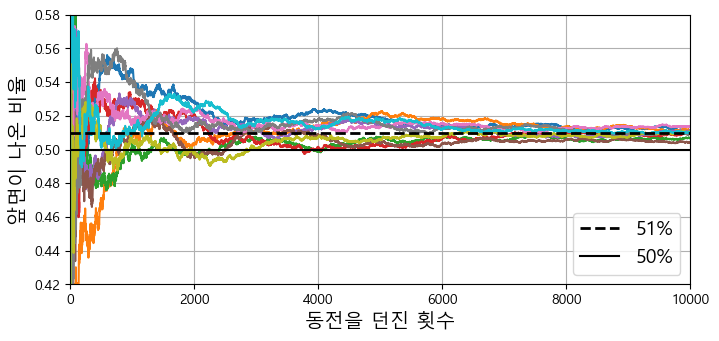

In [20]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', label='50%')
plt.xlabel('동전을 던진 횟수')
plt.ylabel('앞면이 나온 비율')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()


In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [17]:
# estimators에 있는 분류기 각각의 accuracy
for name, clf in voting_clf.named_estimators_.items():
    print(f'{name} = {clf.score(X_test, y_test)}')

lr = 0.864
rf = 0.896
svc = 0.896


In [18]:
# estimators에 있는 분류기 각각이 예측한 class
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

## Hard Vote

In [19]:
# 세가지 분류기의 투표기반 분류기의 acurracy
voting_clf.score(X_test, y_test)

0.912

- 각각의 분류기 보다 투표기반 분류기의 성능이 더 높다.
- 이렇게 class를 직접 투표하여 결정하는 방식을 "직접 투표", 또는 "hard vote"라고 한다.

## Soft Vote

In [27]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

- SVC 클래스의 경우 파라미터 probability=True 로 지정해주면 클래스 확률을 예측할 수 있다.
- 모든 투표에 참여하는 분류기가 클래스 확률을 제공한다면 그 확률의 평균을 통해 클래스 예측을 할 수 있다.
- 이를 "간접 투표", 또는 "soft vote"라고 한다.
- 보통 soft vote의 성능이 hard vote보다 좋다.

# Bagging & Pasting
- Bagging: 중복 허용하여 학습 샘플 샘플링
- Pasting: 중복을 허용하지 않고 학습 샘플 샘플링

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_estimators,500
,max_samples,100
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,0


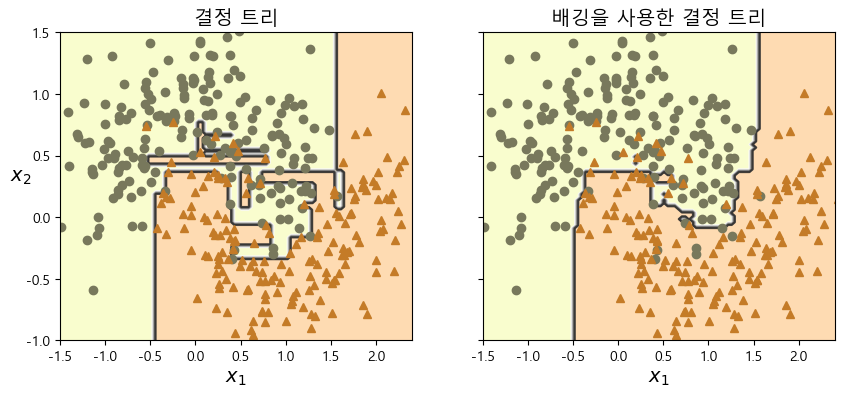

In [39]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap='Greys', alpha=0.8 * alpha)
    colors = ['#78785c', '#c47b27']
    markers = ('o', '^')
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle='none')
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$', rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title('결정 트리')
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title('배깅을 사용한 결정 트리')
plt.ylabel('')
plt.show()

## OBB(Out-Of-Bag) 평가

In [30]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [31]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [32]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

# 랜덤 포레스트

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트는 결정트리의 배깅과 같다

In [36]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [37]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # 동일한 예측

np.True_

## 특성 중요도

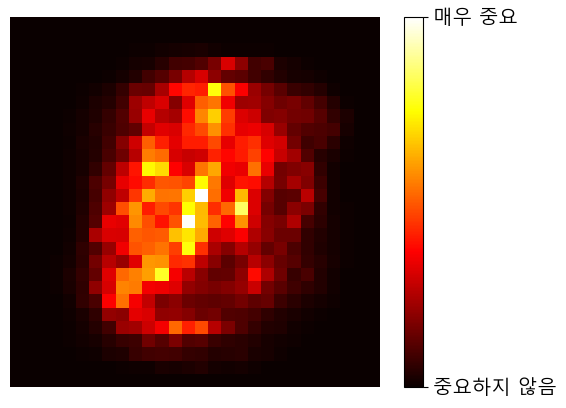

In [40]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

# 특성 중요도 힛햅으로 시각화
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap='hot')
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis('off')
plt.show()

# 부스팅

## AdaBoost

In [ ]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):               # learning rate 1과 0.5 비교
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# 연습문제

In [38]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

In [39]:
X_images =  X_mnist.reshape(-1, 28, 28)

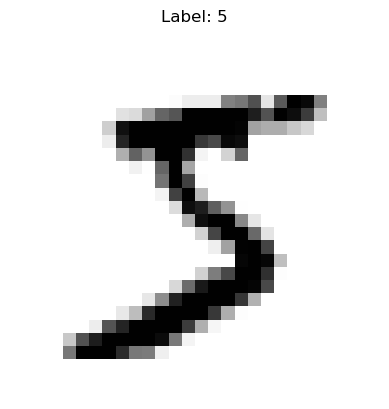

In [40]:
# 시각화
import matplotlib.pyplot as plt

plt.imshow(X_images[0], cmap='gray_r')
label = y_mnist[0]

plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=10000, stratify=y_mnist)

In [43]:
np.unique(y_train)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

## RF, SVM, extra tree, lr, gaussian nb

In [44]:
hard_voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)), # linear regression + softmax
        ('svc', SVC(random_state=42)), # SVC probability 리턴
        ('rfc', RandomForestClassifier(random_state=42)),
        ('etc', ExtraTreesClassifier(random_state=42)),
    ],
    n_jobs=-1,
)

hard_voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('svc', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)), # linear regression + softmax
        ('svc', SVC(probability=True, random_state=42)), # SVC probability 리턴
        ('rfc', RandomForestClassifier(random_state=42)),
        ('etc', ExtraTreesClassifier(random_state=42)),
    ],
    voting='soft',
    n_jobs=-1,
)

soft_voting_clf.fit(X_train, y_train)

In [ ]:
# hard
print('----HARD----')
for name, clf in hard_voting_clf.named_estimators_.items():
    print(f'{name} = {clf.score(X_test, y_test)}')

# soft
print('----SOFT----')
for name, clf in soft_voting_clf.named_estimators_.items():
    print(f'{name} = {clf.score(X_test, y_test)}')

In [ ]:
hard_voting_clf.score(X_test, y_test)

In [ ]:
soft_voting_clf.score(X_test, y_test)